# Unbinned Datasets - Tailored approach

In [1032]:
%matplotlib inline
import gammapy
print(gammapy.__version__)

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import astropy.units as u
from scipy import integrate , interpolate

from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle
from astropy.utils import lazyproperty
from regions import CircleSkyRegion
from gammapy.data import DataStore, Observation, EventList
from gammapy.datasets import MapDataset, MapDatasetEventSampler, SpectrumDataset
from gammapy.estimators import LightCurveEstimator
from gammapy.maps import MapAxis, WcsGeom, Map, MapAxes, WcsNDMap, RegionGeom
from gammapy.irf import load_cta_irfs
from gammapy.makers import MapDatasetMaker, FoVBackgroundMaker, SafeMaskMaker, SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    PointSpatialModel,
    TemplateSpatialModel,
    ExpDecayTemporalModel,
    LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    LogParabolaSpectralModel,
    DatasetModels,
    ExpCutoffPowerLawSpectralModel
)
# from utils import EdispInv

0.20.1


### Load data

In [1033]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
np.unique( np.array( data_store.hdu_table['OBS_ID'] ))

array([20136, 20137, 20151, 20275, 20282, 20283, 20301, 20302, 20303,
       20322, 20323, 20324, 20325, 20326, 20327, 20339, 20343, 20344,
       20345, 20346, 20349, 20350, 20365, 20366, 20367, 20368, 20396,
       20397, 20421, 20422, 20517, 20518, 20519, 20521, 20561, 20734,
       20898, 20899, 20900, 20915, 21613, 21753, 21807, 21824, 21851,
       22022, 22593, 22997, 23040, 23077, 23143, 23246, 23523, 23526,
       23559, 23573, 23592, 23635, 23651, 23736, 25345, 25443, 25511,
       26077, 26791, 26827, 26850, 26964, 27044, 27121, 27939, 27987,
       28341, 28967, 28981, 29024, 29072, 29118, 29177, 29433, 29487,
       29526, 29556, 29683, 33787, 33788, 33789, 33790, 33791, 33792,
       33793, 33794, 33795, 33796, 33797, 33798, 33799, 33800, 33801,
       47802, 47803, 47804, 47827, 47828, 47829])

In [1034]:
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]
obs1.events.table

EVENT_ID,TIME,RA,DEC,ENERGY
,s,deg,deg,TeV
int64,float64,float32,float32,float32
5407363825684,123890826.66805482,84.97964,23.89347,10.352011
5407363825695,123890826.69749284,84.54751,21.004095,4.0246882
5407363825831,123890827.23673964,85.39696,19.41868,2.2048872
5407363825970,123890827.79615426,81.93147,20.79867,0.69548655
5407363826067,123890828.26131463,85.98302,21.053099,0.86911184
5407363826095,123890828.41393518,86.97305,21.837437,4.1240892
...,...,...,...,...
7198365188605,123892511.93477488,82.4973,22.135513,0.5850589


Select events

In [1031]:
events = obs1.events.select_energy( (0.8*u.TeV, 20*u.TeV))
events = events.select_offset(   (0,1.5)*u.deg)    
len(events.table)

1665

# 3D  case

### Custom functions

In [1020]:
def build_true_ra_dec_and_offset( observation,  etrue, radec=None):
    number_of_bins   = 21
    
    if radec is None:
        radec =  observation.events.radec

    
    # DEFINE SIZE BASED ON CONT. RADIUS
    offsets        =  radec.separation( observation.pointing_radec) 
    cont_rad       =  np.array( [cont_radius_interp(etrue[:,k,0,0] , offsets).diagonal() for k in range( etrue.shape[1]) ] )
    separation     =  np.linspace(-cont_rad,cont_rad,number_of_bins) * u.deg

    # CARTESIAN GRID
    true_radec    = radec.directional_offset_by( separation = separation, position_angle=0*u.deg)
    true_radec    = true_radec.directional_offset_by( separation = separation[:,None,:], position_angle=90*u.deg)
    true_radec    = true_radec.T
    delta_ra      = true_radec[:,:,1:,1:].ra - true_radec[:,:,:-1,:-1].ra
    delta_dec     = true_radec[:,:,1:,1:].dec - true_radec[:,:,:-1,:-1].dec
    delta_Omega   = delta_ra * delta_dec
    
    true_radec    = true_radec[:,:,:-1,:-1]

    # distance from rec. direction
    rad                   =   true_radec.separation( radec[:,None,None,None] ) 
     # distance from pointing
    true_offset           =   true_radec.separation( observation.pointing_radec) 
    
    return true_radec, delta_Omega, rad, true_offset 


def build_true_energy( observation, ereco=None):
    number_of_bins   = 21
    
    if ereco is None:
        ereco  =  observation.events.energy
    
    edisp                  = observation.edisp
    edisp.normalize()
    
    migra_min , migra_max  = edisp.axes['migra'].bounds.value
    etrue                  = np.geomspace( ereco/ migra_max, ereco/ migra_min ,number_of_bins)
    etrue                  = etrue.T
    delta_etrue            = np.diff(etrue,axis=1)
    etrue                  = etrue[:,1:]
    
    return etrue[:,:,None,None], delta_etrue[:,:,None,None]


def make_edisp_factors(observation,true_offset, etrue,  ereco=None ):
    if ereco is None:
        ereco =  observation.events.energy
        
    ereco       =  ereco[:,None,None,None]
    
    edisp2D        = observation.edisp
    edisp2D.normalize()
    edisp        =  edisp2D.evaluate( 
                     offset =true_offset,
                     energy_true=etrue,
                     migra=ereco/etrue 
                    ) / etrue
    return edisp


def make_aeff_factors(observation, true_offset, etrue):
    
    aeff         = observation.aeff.evaluate(offset=true_offset , energy_true=etrue)
    return aeff

def make_psf_factors( observation, true_offset, etrue, rad):
    psf3d        = observation.psf
    psf3d.normalize()
    
    psf_factors = psf3d.evaluate(
                    energy_true=etrue, 
                    rad=rad, 
                    offset=true_offset
                ) 
    
    return psf_factors


def convolve_irf(model, psf, edisp, aeff,  etrue, detrue, true_ra_dec, domega):#, drad):
    
    lon      = true_ra_dec.galactic.l
    lat      = true_ra_dec.galactic.b

    phi_true = model( energy= etrue , lon=lon, lat=lat  ) 
    phi_obs  = np.sum(  phi_true * aeff  * edisp * detrue *   psf_factors * domega   , axis=(1,2,3)) 
    return phi_obs
    

def convolve_irf2(spectral_model, edisp, aeff, etrue, detrue):
    return np.sum( edisp * spectral_model(etrue) * aeff * detrue  , axis=1)

### Create Dataset from observation

In [1014]:
crab_pos = SkyCoord(184.507, -5.734, unit='deg', frame='galactic') 
obs_pos=obs1.pointing_radec
ebins = np.logspace(-1,2,49)
energy_axis = MapAxis.from_edges(
    ebins, unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.2, 5, nbin=160, node_type="edges", name="migra"
)
geom = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.1,
    width=(5.5, 5.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)
geom_true = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.1,
    width=(5.5, 5.5),
    frame="icrs",  # same frame as events
    proj="CAR",
    axes=[energy_axis_true],
)

circle = CircleSkyRegion(
    center=crab_pos, radius=0.3 * u.deg
)
data = geom.region_mask(regions=[circle], inside=False)
exclusion_mask = ~geom.region_mask(regions=[circle])
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)


maker = MapDatasetMaker( selection=['psf','edisp','exposure','counts'],background_oversampling=2)
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max='1.5 deg', bias_percent=8)
reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)  #, migra_axis=migra_axis

dataset = maker.run(reference, obs1)
dataset = maker_safe_mask.run(dataset, obs1)
dataset.mask_safe *= geom.energy_mask(energy_min=1*u.TeV)
# assert np.isfinite(dataset.background.data[dataset.mask_safe.data]).all()
# dataset.background.data[~dataset.mask_safe.data] = 0.0

#bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
#dataset.models=bkg_model

model_gauss = SkyModel(
    spatial_model  = GaussianSpatialModel(     lon_0     = "184.557 deg",           lat_0     = "-5.784 deg", sigma = '1 deg', frame = 'galactic'),
    spectral_model = LogParabolaSpectralModel( amplitude ='3.5e-11 cm-2 s-1 TeV-1', reference = '1 TeV',      alpha = 1.8,       beta  = 0.4),
    name           = 'crab_model_gauss'
)


dataset.models = [model_gauss]

### Plot it

<WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>

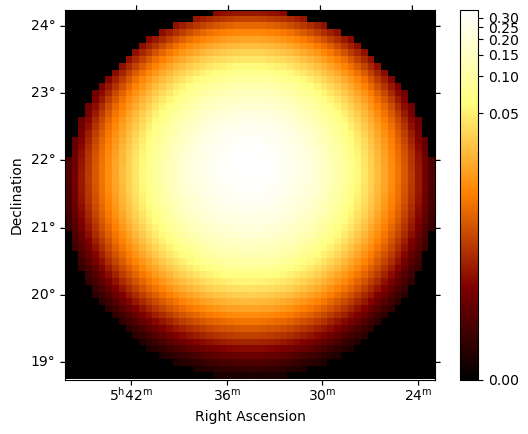

In [1035]:
mapnpred      = dataset.npred()
mapnpred      = dataset.evaluators['crab_model_gauss'].compute_npred()

mapnpred.sum_over_axes().plot(add_cbar=True,stretch='log')

1665

# Get containment radius for differen $E_{true}$ and "offsets"

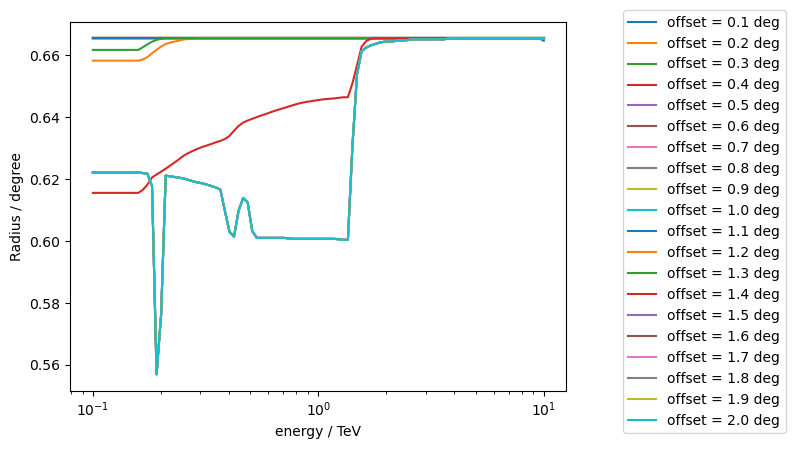

In [1030]:
migra_min , migra_max  = obs1.edisp.axes['migra'].bounds.value
ereco_events           =  events.energy
etrue_min , etrue_max  = np.min( ereco_events/ migra_max ), np.max( ereco_events/ migra_min)
etrue                  = np.geomspace(etrue_min, etrue_max  ,100)

#etrue                  = np.geomspace( 0.1*u.TeV, 100*u.TeV  ,50)

max_offset         = np.max( events.radec.separation( obs1.pointing_radec) )
offset             = np.linspace( 0*u.deg, max_offset, 100)
cont_radius        = obs1.psf.containment_radius(energy_true=etrue[:,None], offset=offset[None,:], fraction=(0.9999))
cont_radius_interp = interpolate.interp2d( etrue, offset, cont_radius)

for o in np.linspace(0.1,2,20)*u.deg :
    x = np.geomspace(0.1, 10,100)*u.TeV
    y = cont_radius_interp(x,o)

    plt.plot(x,y, label = "offset = "+str(np.round(o,2)))
    plt.semilogx()
    plt.xlabel('energy / TeV')
    plt.ylabel('Radius / degree')
plt.legend(bbox_to_anchor=(1.1, 1.05))

### True Energy Grid

[]

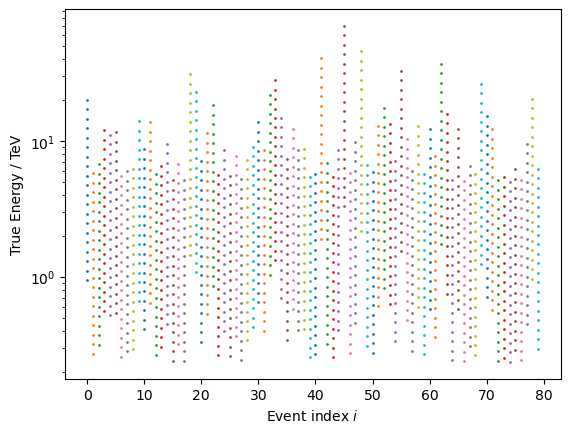

In [133]:
for i_event in range(80):
    y = etrue[i_event,:,0,0]
    x = np.ones_like(y)*i_event # np.ones_like(y)*events.energy[i_event]#
    plt.scatter(x, y,s=1)
    

plt.xlabel(r'Event index $i$')
#plt.xlabel('Event observed Energy / TeV')
plt.ylabel('True Energy / TeV')
plt.semilogy()
#plt.loglog()

# SOME PLOTTING

# We can now build the edisp, aeff, and psf tensors
# with shape given by (N, e, x, y) where:
- N : total number of events
- e : number of bins in true energy
- x : number of bins in ra coodinate
- y : number of bins in dec coodinate

In [1036]:
%%time

radec = events.radec
ereco = events.energy

etrue, detrue                              = build_true_energy(            obs1,  ereco )
true_radec, delta_omega, rad, true_offset  = build_true_ra_dec_and_offset( obs1,  etrue, radec) 


lon_true      = true_radec.galactic.l
lat_true      = true_radec.galactic.b


edisp         = make_edisp_factors( obs1, true_offset, etrue, ereco)

psf           = make_psf_factors(   obs1, true_offset, etrue, rad)

aeff          = make_aeff_factors(  obs1, true_offset, etrue)


IRF      = aeff  * edisp  *   psf * delta_omega  * detrue

livetime = obs1.obs_info['LIVETIME'] * u.s

IRF *= livetime

CPU times: user 11.7 s, sys: 2.06 s, total: 13.7 s
Wall time: 13.9 s


In [1022]:
IRF.shape

(1665, 20, 20, 20)

In [1037]:
IRF.unit

Unit("m2 s")

# We can now finally multiply the true flux computed over the grid 3-dimensional grid ($E_{true}$, rad, dec) 
# with the IRF in order t get the flux computed over each event

In [1038]:
%%time 
phi_true = dataset.models[0]( energy= etrue , lon=lon_true, lat=lat_true  ) 

phi_obs = np.sum( IRF * phi_true, axis=(1,2,3)) 

phi_obs = phi_obs.to( 1/u.Unit( "TeV sr" ))

CPU times: user 574 ms, sys: 36.1 ms, total: 610 ms
Wall time: 611 ms


## Comparison with interpolation computation

In [1039]:
ereco_events     = events.energy
lon_events       = events.radec.galactic.l
lat_events       = events.radec.galactic.b
sep_event_model  = events.radec.separation(model_gauss.position)

In [1040]:
mapnpred        = dataset.npred()

mapnpred = dataset.npred()

mapnpred = dataset.evaluators['crab_model_gauss'].compute_npred()


mapnpred2       = mapnpred.copy()
mapnpred2.data  = mapnpred.data/ mapnpred.geom.bin_volume().to( "TeV sr" ).value
flux_interp     = mapnpred2.interp_by_coord( events.map_coord( mapnpred2.geom ))/ u.Unit( "TeV sr" )

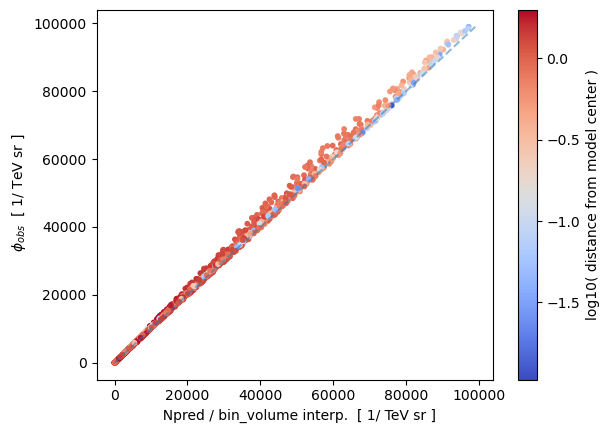

In [1041]:
# color coding
c =  sep_event_model.value

scatter = plt.scatter( flux_interp, phi_obs ,  c= np.log10(c), cmap='coolwarm', s=10)
plt.xlabel('  Npred / bin_volume interp.  [ 1/ TeV sr ]')
plt.ylabel(r' $\phi_{obs} $  [ 1/ TeV sr ]')
cbar = plt.colorbar( scatter)
cbar.set_label( 'log10( distance from model center )')

x = np.linspace(0, np.max( [np.max( flux_interp.value), np.max( phi_obs.value )] ) ,1000)

plt.plot(x,x, '--', alpha=0.5)

#plt.loglog()

## Plot the events on the ra - dec grid

In [1042]:
phi_true  = dataset.models[0]( energy= ereco_events, lon= lon_events, lat = lat_events)

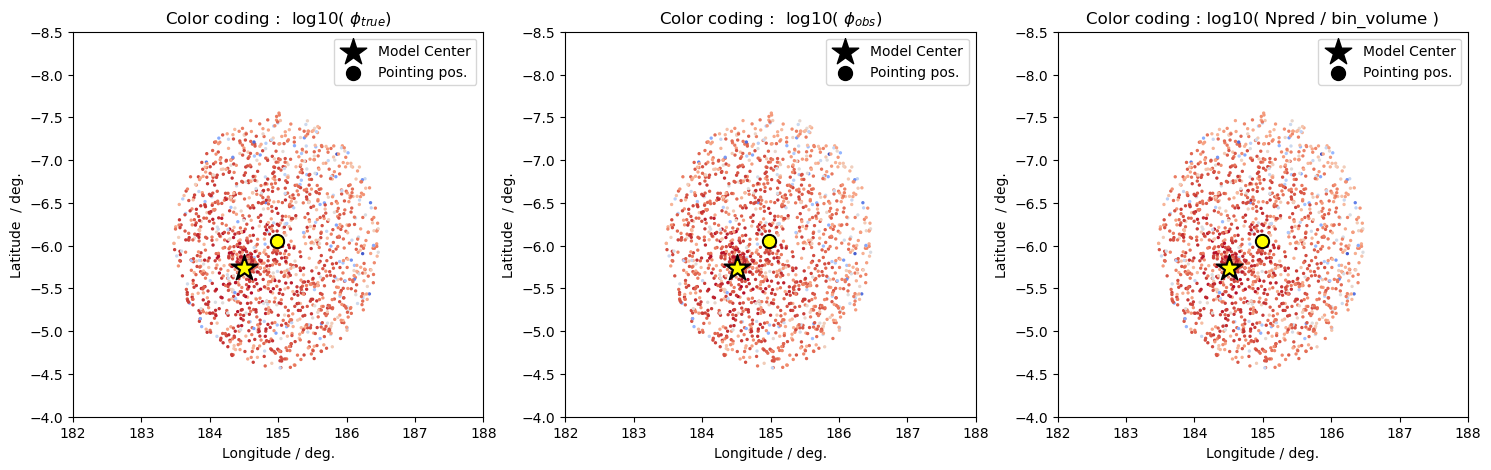

In [1043]:
fig, ax = plt.subplots(figsize=(18,5), nrows=1, ncols=3)

all_c = [ np.log10( phi_true.value), np.log10( phi_obs.value) , np.log10( flux_interp.value ) ]

all_titles = [r"Color coding :  log10( $\phi_{true}$)",  r"Color coding :  log10( $\phi_{obs}$)",  "Color coding : log10( Npred / bin_volume )"]

for i in range(3):
    scatter = ax[i].scatter( lon_events, lat_events,s=2,    c= all_c[i] , cmap='coolwarm')
    
    ax[i].set_xlabel( "Longitude / deg.")
    ax[i].set_ylabel( "Latitude  / deg.")
    ax[i].set_xlim(182,188)
    ax[i].set_ylim(-4,-8.5)

    ax[i].scatter(crab_pos.l, crab_pos.b, marker='*', c='black', s=400,label='Model Center')
    ax[i].scatter(crab_pos.l, crab_pos.b, marker='*', c='yellow', s=100, )
    ax[i].scatter( obs1.pointing_radec.galactic.l, obs1.pointing_radec.galactic.b, marker='o', c='black', s=100,label='Pointing pos.')
    ax[i].scatter( obs1.pointing_radec.galactic.l, obs1.pointing_radec.galactic.b, marker='o', c='yellow', s=50, )
    
    ax[i].set_title(all_titles[i])

    ax[i].legend()

#cbar = plt.colorbar(scatter)
#cbar.set_ticklabels('')
#cbar.set_label('log10( ')

# Some plotting

### True Ra,Dec Grid

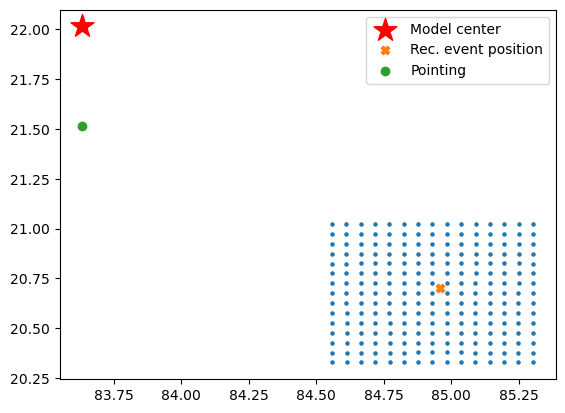

In [ ]:
i_event = [310]
x = true_radec[i_event,5,:,:].ra
y = true_radec[i_event,5,:,:].dec
plt.scatter( x,y, s=5 )
    
plt.scatter( model_gauss.position.icrs.ra, model_gauss.position.icrs.dec, marker='*',color='red',s=300,label='Model center')
plt.scatter( events.radec[i_event].ra, events.radec[i_event].dec, marker='X',label='Rec. event position')
plt.scatter( obs1.pointing_radec.ra, obs1.pointing_radec.dec, marker='o', label='Pointing')
plt.legend();

With color coding given by the true energy

(82.53885731296253, 87.0)

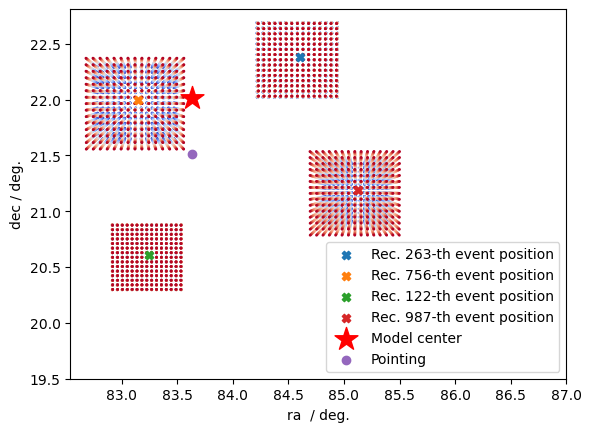

In [ ]:
for i_event in [263,756,122,987]:
    all_ra    = []
    all_dec   = []
    all_c = []
    for k,et in enumerate( etrue[i_event,:] ):
        ra  = true_radec[i_event,k,:,:].ra
        dec = true_radec[i_event,k,:,:].dec
        c = np.resize( et, np.shape(x))
        all_ra.append( ra)
        all_dec.append(dec)
        all_c.append( c.value)
        

    plt.scatter( all_ra,all_dec, s=1, c= np.log(all_c), cmap='coolwarm')
    
    plt.scatter( events.radec[i_event].ra, events.radec[i_event].dec, marker='X',label='Rec. '+str(i_event)+'-th event position')
    
plt.scatter( model_gauss.position.icrs.ra, model_gauss.position.icrs.dec, marker='*',color='red',s=300,label='Model center')

plt.scatter( obs1.pointing_radec.ra, obs1.pointing_radec.dec, marker='o', label='Pointing')
plt.xlabel('ra  / deg.')
plt.ylabel('dec / deg.')
plt.legend(loc='lower right');
plt.ylim([19.5,None])
plt.xlim([None,87])

1.7731415033340454 TeV
<SkyCoord (ICRS): (ra, dec) in deg
    (85.12618256, 21.18725395)>


Text(0, 0.5, 'dec / deg.')

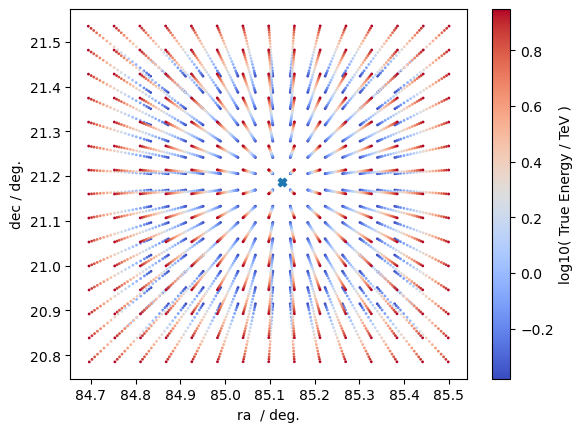

In [ ]:
for i_event in [987]:
    print( events.energy[i_event])
    print( events.radec[i_event])
    all_ra    = []
    all_dec   = []
    all_c = []
    for k,et in enumerate( etrue[i_event,:] ):
        ra  = true_radec[i_event,k,:,:].ra
        dec = true_radec[i_event,k,:,:].dec
        c = np.resize( et, np.shape(ra))
        all_ra.append( ra)
        all_dec.append(dec)
        all_c.append( c.value)
        

    scatter = plt.scatter( all_ra,all_dec, s=1, c= np.log10(all_c), cmap='coolwarm')
    
    plt.scatter( events.radec[i_event].ra, events.radec[i_event].dec, marker='X',label='Rec. '+str(i_event)+'-th event position')
    
    cbar = plt.colorbar(scatter)
    cbar.set_label('log10( True Energy / TeV )')

plt.xlabel('ra  / deg.')
plt.ylabel('dec / deg.')

### The 'offset', i.e. the distabce from the pointing

Text(0, 0.5, 'offset / deg.')

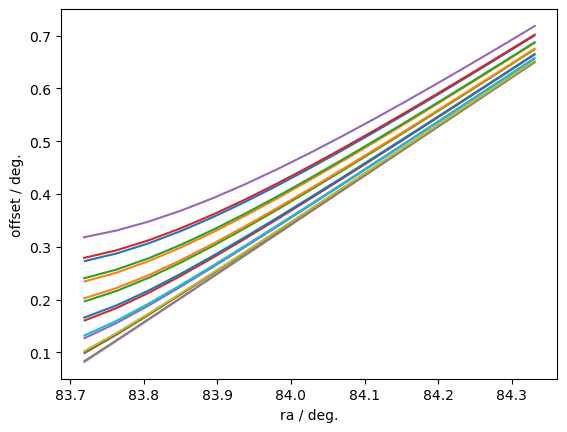

In [ ]:
for i_event in [110]:
    for i in range( np.shape(rad)[2]):
        y = true_offset[i_event,5,i,:]
        y = y.flatten()
        x = true_radec[i_event,5,i,:].ra
        plt.plot( x, y) #
        
plt.xlabel('ra / deg.')
plt.ylabel('offset / deg.')

### The radius 'rad' , i.e. the distance from the reconstructed position

Text(0, 0.5, 'rad / deg.')

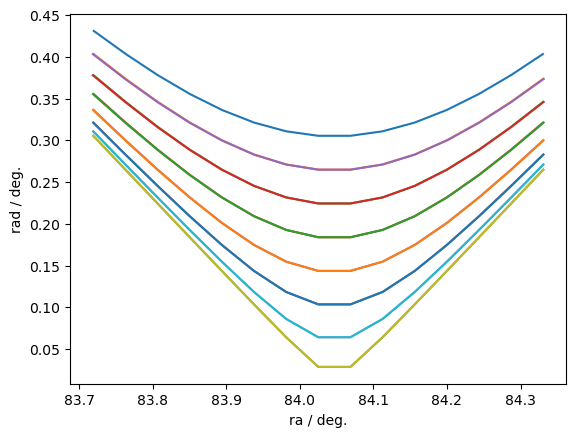

In [ ]:
for i_event in [110]:
    for i in range( np.shape(rad)[2]):
        y = rad[i_event,5,i,:]
        y = y.flatten()
        x = true_radec[i_event,5,i,:].ra
        plt.plot( x, y) #
        
plt.xlabel('ra / deg.')
plt.ylabel('rad / deg.')

### Plot of Edips and PSF

Text(0.5, 0, 'True Energy / TeV')

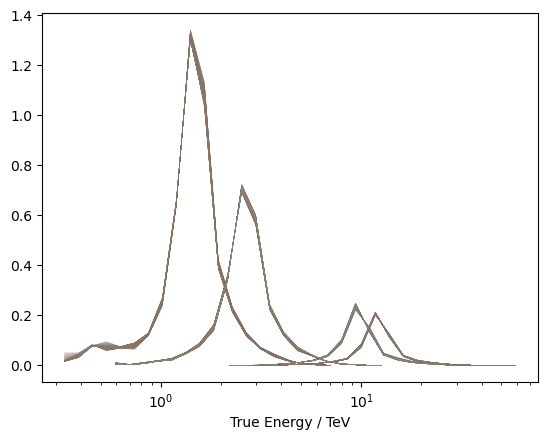

In [ ]:
for i_event in [133,124, 276, 86]:
    for i in range( np.shape(edisp)[2]):
        for j in range( np.shape(edisp)[3]):
            plt.plot( etrue[i_event,:,0,0],edisp[i_event,:,i,j],linewidth=0.2 , alpha=0.5)
plt.xscale('log')
plt.xlabel('True Energy / TeV')

2.7987732887268066 TeV
1.742950201034546 TeV
4.39040994644165 TeV
2.2802631855010986 TeV
3.0365006923675537 TeV


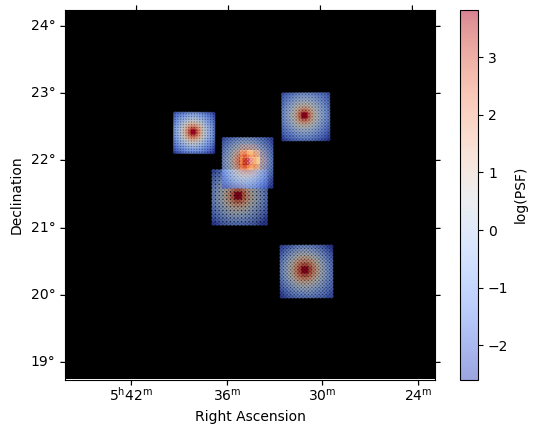

In [ ]:
mmapnpred = dataset.npred()
model_true=model_gauss.integrate_geom(mmapnpred.geom.as_energy_true)
model_true.sum_over_axes().plot()
ax = plt.gca()
for i_event in [485,10,32,21,70]:
    print(events.energy[i_event])
    x = true_radec[i_event,5,:,:].ra.flatten()
    y = true_radec[i_event,5,:,:].dec.flatten()
    c = psf_factors[i_event, 5, :, :].flatten().value
    scatter = ax.scatter( x,y, s=5, c= np.log(c), cmap='coolwarm', transform=ax.get_transform('world'),alpha=0.5)
    
cbar = plt.colorbar(scatter)
cbar.set_label('log(PSF)')

# 1D CASE

In [1044]:
crab_pos = SkyCoord(184.507, -5.734, unit='deg', frame='galactic') 
obs_pos=obs1.pointing_radec
ebins = np.logspace(-1,2,360)
energy_axis = MapAxis.from_edges(
    ebins, unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.2, 5, nbin=360, node_type="edges", name="migra"
)

on_region_radius = Angle("2.5 deg")
on_region = CircleSkyRegion(center=crab_pos, radius=on_region_radius)

geom = RegionGeom.create(on_region, axes=[energy_axis])

maker = SpectrumDatasetMaker( selection=['edisp','exposure','counts'])
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max='1.5 deg', bias_percent=8)
reference = SpectrumDataset.create( geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)  

dataset = maker.run(reference, obs1)
dataset = maker_safe_mask.run(dataset, obs1)
dataset.mask_safe *= geom.energy_mask(energy_min=1*u.TeV)

model_gauss = SkyModel(
    spectral_model = LogParabolaSpectralModel( amplitude ='3.5e-11 cm-2 s-1 TeV-1', reference = '1 TeV',      alpha = 1.8,       beta  = 0.4),
    name           = 'crab_model_gauss'
)


dataset.models = [model_gauss]

In [1045]:
events = obs1.events.select_energy( (0.5*u.TeV, 20*u.TeV))
events = events.select_offset(   (0,2.5)*u.deg)  
len(events.table)

6104

Text(0.5, 0, 'Npred ')

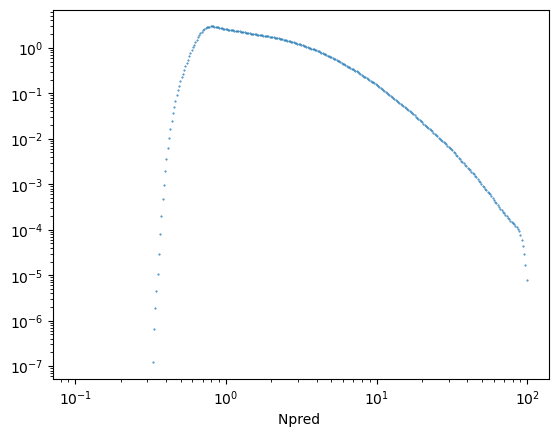

In [1049]:
y = dataset.npred().data.flatten()
x = dataset.geoms['geom'].axes['energy'].center
plt.scatter(x,y, s=0.2)
plt.loglog()
plt.xlabel('Energy / TeV ')
plt.xlabel('Npred ')          

In [1050]:
def build_true_energy( observation, ereco=None):
    number_of_bins = 201
    if ereco is None:
        ereco  =  observation.events.energy
    
    edisp                  = observation.edisp
    migra_min , migra_max  = edisp.axes['migra'].bounds.value
    etrue                  = np.geomspace( ereco/ migra_max, ereco/ migra_min ,number_of_bins)
    etrue                  = etrue.T
    delta_etrue            = np.diff(etrue,axis=1)
    etrue                  = etrue[:,1:]
    
    return etrue, delta_etrue

def make_edisp_factors(observation, etrue,  ereco=None ):
    if ereco is None:
        ereco =  observation.events.energy
        
    ereco       =  ereco[:,None]
    
    offset = observation.pointing_radec.separation( crab_pos)
    
    edisp2D        = observation.edisp
    edisp2D.normalize()
    edisp        =  edisp2D.evaluate( 
                     offset = offset,
                     energy_true=etrue,
                     migra=ereco/etrue 
                    ) / etrue
    return edisp


def make_aeff_factors(observation, etrue):
    offset   = observation.pointing_radec.separation( crab_pos)
    aeff     = observation.aeff.evaluate(offset=offset , energy_true=etrue)
    return aeff

In [1051]:
%%time

radec = events.radec
ereco = events.energy

etrue, detrue    = build_true_energy(    obs1,  ereco )


lon_true      = crab_pos.galactic.l
lat_true      = crab_pos.galactic.b


edisp         = make_edisp_factors( obs1, etrue, ereco)

aeff          = make_aeff_factors(  obs1,  etrue)


IRF      =     aeff  * edisp * detrue 

livetime = obs1.obs_info['LIVETIME'] * u.s

IRF *= livetime

CPU times: user 367 ms, sys: 145 ms, total: 512 ms
Wall time: 590 ms


In [1052]:
%%time 

mm = dataset.models[0]

phi_true =  mm.spectral_model( energy= etrue   ) 
print( phi_true.unit )

phi_obs = np.sum( IRF * phi_true, axis=(1)) 
phi_obs = phi_obs.to( 1/u.Unit( "TeV" ))

1 / (cm2 s TeV)
CPU times: user 31.1 ms, sys: 9.52 ms, total: 40.6 ms
Wall time: 50 ms


In [1053]:
mapnpred        = dataset.npred()
mapnpred2       = mapnpred.copy()
omega           = on_region.radius**2 * np.pi
mapnpred2.data  = mapnpred.data/ mapnpred.geom.bin_volume().to( "TeV sr" ).value *  omega.to( 'sr').value
flux_interp     = mapnpred2.interp_by_coord( events.map_coord( mapnpred2.geom ))/ u.Unit( "TeV"  )

(0.2, 20.0)

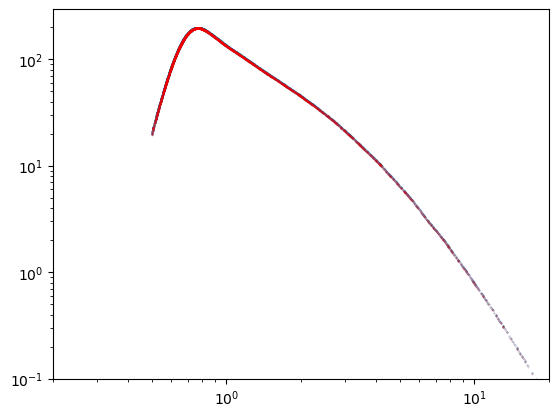

In [1054]:
y = dataset.npred().data.flatten()
x = dataset.geoms['geom'].axes['energy'].center
plt.scatter(ereco,flux_interp,alpha=0.5,s=0.1)
plt.loglog()

plt.scatter( ereco, phi_obs,s=0.1,c='red', alpha=0.2)
plt.loglog()

plt.ylim(1e-1,None)
plt.xlim(2e-1,2e1)

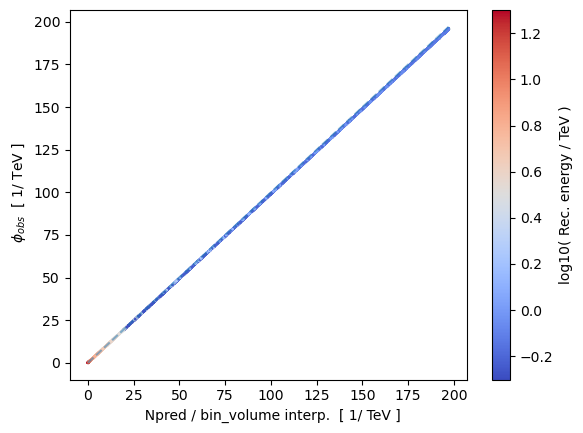

In [1055]:
# color coding
c =  ereco.value

scatter = plt.scatter( flux_interp, phi_obs ,  c= np.log10(c), cmap='coolwarm', s=1)
plt.xlabel('  Npred / bin_volume interp.  [ 1/ TeV ]')
plt.ylabel(r' $\phi_{obs} $  [ 1/ TeV ]')
cbar = plt.colorbar( scatter)
cbar.set_label( 'log10( Rec. energy / TeV )')

x = np.linspace(0, np.max( [np.max( flux_interp.value), np.max( phi_obs.value )] ) ,1000)

plt.plot(x,x, '--', alpha=0.5)

#plt.loglog()